# Virtual Distillation
We perform the full protocol for the 3-copies case, and check the behavior under some noise models.

In [1]:
import qutip
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from functions import *

RUN_FOCK  = True # True
RUN_BINOM = False # True
RUN_CAT   = False # True
RUN_GKP   = False

N = 10 # Total dimension of the space. We will use three copies so N^3 size matrices

### Initial noisy Fock state preparation

Kraus operators $\hat A_k(t)=\dfrac{(1-e^{-\kappa t})^{k/2}}{\sqrt{k!}}e^{-\kappa \hat n t/2}\hat a^k$.
$$\hat\rho(t)=\sum_{k=0}^\infty\hat A_k(t)\hat\rho_0\hat A_k(t)^\dagger$$

with $\rho_0=\ket n\bra n$


For multi-mode $\hat a, \hat b, \dots,\hat c$ we define the same way $\hat A_k, \hat B_k,\dots \hat C_k$ and
$$\hat\rho(t)=\sum_{k=0}^\infty\sum_{l=0}^\infty\dots\sum_{m=0}^\infty\hat A_k\hat B_l\dots\hat C_m\hat\rho_0 \hat A_k^\dagger\hat B_l^\dagger\dots\hat C_m^\dagger$$

In [2]:
n = 3     # number of photons in the initial state
T_1 = 500 # μs
kappa = 1/T_1 #
t_max = 100 # μs (such that κt~0.01-0.1)

nb_samples = 20
t_list = np.linspace(0,t_max,nb_samples)
    
rho_list = create_states(N, t_list, rho_0 = qutip.fock_dm(N,n), kappa=kappa)

Because the resulting initial states are diagonal in the Fock basis, i.e. of the form $\sum_kc_k\ket k\bra k$, we can represent them using a bar chart of the coefficients $c_k$.

Text(0.5, 1.0, 't=100.000')

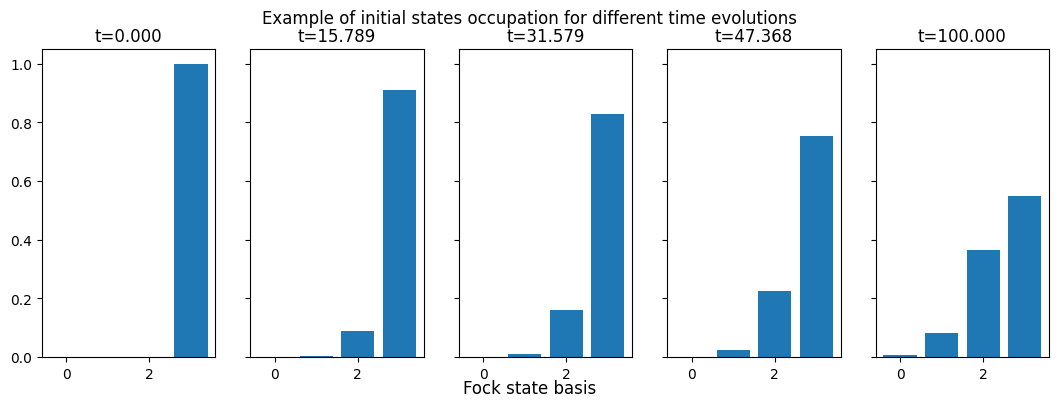

In [3]:
nb_plots = 4
f, axes = plt.subplots(1, nb_plots+1, sharey=True, figsize=(13,4))
f.suptitle("Example of initial states occupation for different time evolutions")
f.supxlabel("Fock state basis")
for i in range(nb_plots):
    axes[i].bar(np.arange(n+1),np.abs(np.diag(rho_list[3*i]))[:n+1])
    axes[i].set_title(f't={t_list[3*i]:.3f}')
axes[nb_plots].bar(np.arange(n+1),np.abs(np.diag(rho_list[nb_samples-1]))[:n+1])
axes[nb_plots].set_title(f't={t_list[nb_samples-1]:.3f}')

### Virtual Distillation protocol
We perform the protocol for $M=3$ copies of the noisy input state using the diagonalizing method. This is done by applying three successive beam splitter operations on the 3-mode system, resulting in the following gate:
$$\hat{\mathcal F}_3=e^{\frac{i\pi}4(\hat a_1^\dagger \hat a_2+\hat a_2^\dagger \hat a_1)}e^{i\arcsin{(\frac1{\sqrt3})}(\hat a_3^\dagger \hat a_2+\hat a_2^\dagger \hat a_3)}e^{\frac{i\pi}4(\hat a_3^\dagger \hat a_1+\hat a_1^\dagger \hat a_3)}$$

To assess the robustness of the protocol, we add some coherent error on the angle of the beam splitter, modelized by a Gaussian distribution.

$$\hat{\mathcal F}_3(\varepsilon)=e^{i\left(\frac{\pi}4+\varepsilon_1\right)(\hat a_1^\dagger \hat a_2+\hat a_2^\dagger \hat a_1)}e^{i\left(\arcsin{(\frac1{\sqrt3})}+\varepsilon_2\right)(\hat a_3^\dagger \hat a_2+\hat a_2^\dagger \hat a_3)}e^{i\left(\frac{\pi}4+\varepsilon_3\right)(\hat a_3^\dagger \hat a_1+\hat a_1^\dagger \hat a_3)}$$
with
$$\varepsilon=(\varepsilon_1,\varepsilon_2,\varepsilon_3)\sim \mathcal N(0,\sigma)$$

We also consider uncoherent losses during the protocol in between each beam splitter gate, which are however proven to commute with the beam splitter operators, so the expected curve should appear as shifted to the left compared to the one without losses.

Here is where we compute the noisy $\mathcal F_3$ gates (this is the most costly operation). We will then average the results and compute their standard deviation.

In [4]:
nb_F_samples = 30
eps_std = np.pi/40
initial_sin_angles = np.sqrt((1/2,1/3,1/2))

try: # to avoid recalculating everything when rerunning only some of the cells of the Notebook
    recalc += 1
except NameError:
    if RUN_FOCK or RUN_BINOM or RUN_CAT or RUN_GKP:
        noise_list = np.random.normal(0,eps_std,(nb_F_samples,3))
        F_list = [] # list of triplets of beam splitters
        for (i,noise) in enumerate(noise_list):
            if (i%1==0): print(f"{i+1}/{nb_F_samples}", end=" ")
            F_list.append(create_F3(N, initial_sin_angles, noise))
        recalc = 0

1/30 2/30 3/30 4/30 5/30 6/30 7/30 8/30 9/30 10/30 11/30 12/30 13/30 14/30 15/30 16/30 17/30 18/30 19/30 20/30 21/30 22/30 23/30 24/30 25/30 26/30 27/30 28/30 29/30 30/30 

After applying the diagonalizing gate, we obtain
$$\tilde \rho=\hat{\mathcal F}_3\rho^{\otimes 3}\hat{\mathcal F}_3^\dagger$$
We can then measure $\hat n_1$, $\hat n_2$, $\hat n_3$ and by repeating the experiment retrieve
$$ \operatorname{den}=\left\langle\hat{\mathcal R_3}\right\rangle =\left\langle\exp\left(\frac{2i\pi}3(\hat n_1+2\hat n_2)\right)\right\rangle \quad\text{and}\quad \operatorname{num}=\left\langle\hat n^{(3)}\hat{\mathcal R_3}\right\rangle = \left\langle\frac{\hat n_1+\hat n_2+\hat n_3}3e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle$$
Instead of averaging on many experiments, here we directly compute the expectation values (this should be faster thanks to qutip).
We compare
$$\frac{\operatorname{num}}{\operatorname{den}}\;,\quad \frac{\operatorname{tr}\left(\hat n\hat\rho^3\right)}{\operatorname{tr}\left(\hat\rho^3\right)}\;,\quad\text{and}\quad \operatorname{tr}(\hat n\hat\rho)$$
which correspond to computed result, theoretical result and no-VD result.

$$\Rightarrow\left\langle\hat n\right\rangle_{VD}=\frac{\left\langle\frac{\hat n_1+\hat n_2+\hat n_3}3e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle}{\left\langle e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle}$$

In [5]:
if RUN_FOCK:
    uncoherent_t_loss = 10 # μs
    result, result_loss, result_th = perform_protocol(N, rho_list, F_list,
                                                      losses=False, uncoherent_t_loss=uncoherent_t_loss)
    result_th_3, result_th_4, result_withoutVD = result_th

# To add uncoherent losses, switch losses to True

We have to be careful that the numerical errors coming from truncation of Hilbert space are not too important : check that S is doing the appropriate thing (only zeroes and ones should appear below (up to phase))

In [6]:
bs1, bs2, bs3 =create_F3(N, initial_sin_angles, np.zeros(3))
           
check_S_operator(N, n, bs1, bs2, bs3)

True
<233|S|233> =  0.0
<233|S|323> =  0.0
<233|S|332> =  1.0
<323|S|233> =  1.0
<323|S|323> =  0.0
<323|S|332> =  0.0
<332|S|233> =  0.0
<332|S|323> =  0.9999999999999999
<332|S|332> =  0.0


### Plots

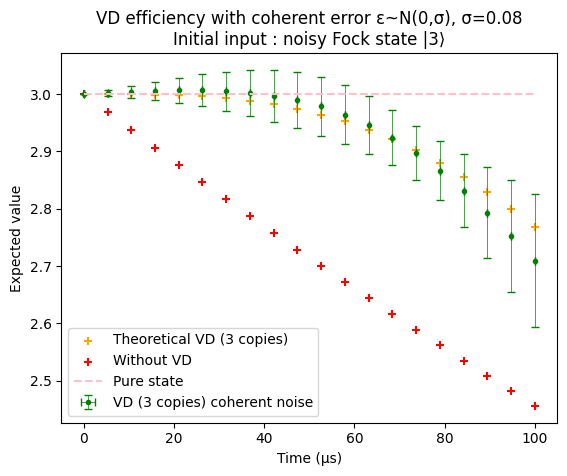

In [30]:
if RUN_FOCK:
    plot_all(t_list, result, result_loss,
             [(result_th_3, "Theoretical VD (3 copies)"),
              (result_withoutVD, "Without VD"), 
              #(result_th_4, "Theoretical VD (4 copies)")
              ],
             (4,1.5), eps_std=eps_std, uncoherent_t_loss=uncoherent_t_loss, kappa=kappa,
             show_curves=None, title="Fock state |3⟩",  losses=False)
    

# To add result without VD, remove the comment in the plot_all call above
# To show also theoretical curves, switch show_curves to n (works only for Fock states)

In [8]:
try: print(noise_list[np.where(np.any(np.abs(result) > n+1, 0))[0][0]] )# extreme value removed
except:print("Nothing removed")

Nothing removed


# -- Other input states --
We try with other input states :
$$\ket\psi=\frac{\ket0+\ket4}{\sqrt2}$$
and
$$\ket\phi=\frac{\ket\alpha+\ket{-\alpha}}{\sqrt2}$$
and later GKP

<BarContainer object of 10 artists>

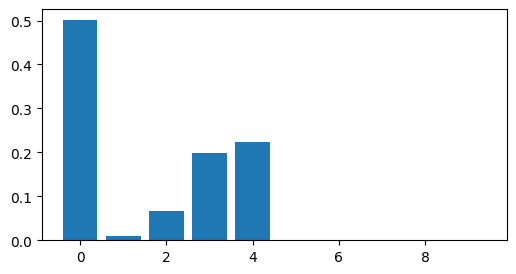

In [9]:
rho_binomial = qutip.ket2dm((qutip.fock(N,0) + qutip.fock(N,4)).unit())

noisy_binomial_list = create_states(N, t_list, rho_binomial, kappa)
f, ax = plt.subplots(1, 1, sharey=True, figsize=(6,3))
ax.bar(np.arange(N), np.abs(np.diag(noisy_binomial_list[-1])))

In [10]:
if RUN_BINOM:
    result_binomial, result_binomial_loss,result_binomial_th = perform_protocol(N, rho_list, F_list, losses=False)

In [11]:
if RUN_BINOM:
    plot_all(t_list, result_binomial, result_binomial_loss,
             [(result_binomial_th[0], "Theoretical 3-mode"), #(result_binomial_th[2],"Without VD"),
            (result_binomial_th[1], "Theoretical 4-mode")], (3,0.5), "Binomial state",
             eps_std, uncoherent_t_loss, kappa, None, losses=False)

In [12]:
alpha = np.sqrt(2)
rho_cat = qutip.ket2dm((qutip.coherent(N, alpha) + qutip.coherent(N, -alpha)).unit())

nb_samples_cat = 7 # less samples to avoid too long computation
t_list_cat = t_list[:nb_samples_cat]
noisy_cat_list = create_states(N, t_list_cat, rho_cat, kappa)
if RUN_CAT:
    result_cat, result_cat_loss, result_cat_th = perform_protocol(N, noisy_cat_list, F_list[:nb_samples_cat], [1,3], losses=False)


In [13]:
if RUN_CAT:
    plot_all(t_list_cat, result_cat, result_cat_loss, [(result_cat_th[0], "No VD"), 
                        (result_cat_th[1], "Theoretical 3-mode")], (6,0), "Cat state", losses=False)

Finitely squeezed GKP state

$$\ket{0_\delta}=e^{-\delta^2\left(\hat n+\frac12\right)}\ket{0^{(\text{ideal})}}\qquad\text{where}\qquad \ket{0^{(\text{ideal})}}=\sum_{n=-\infty}^\infty\ket{2n\sqrt\pi}_q$$

Other form for small $\delta$:
$$\ket{0_\delta}\propto\sum_{s\in\mathbb Z}e^{-\pi s^2\tanh\delta^2}\hat D(2s\sqrt\pi)\hat S(-\ln\sqrt{\sinh\delta^2\cosh\delta^2})\ket0$$

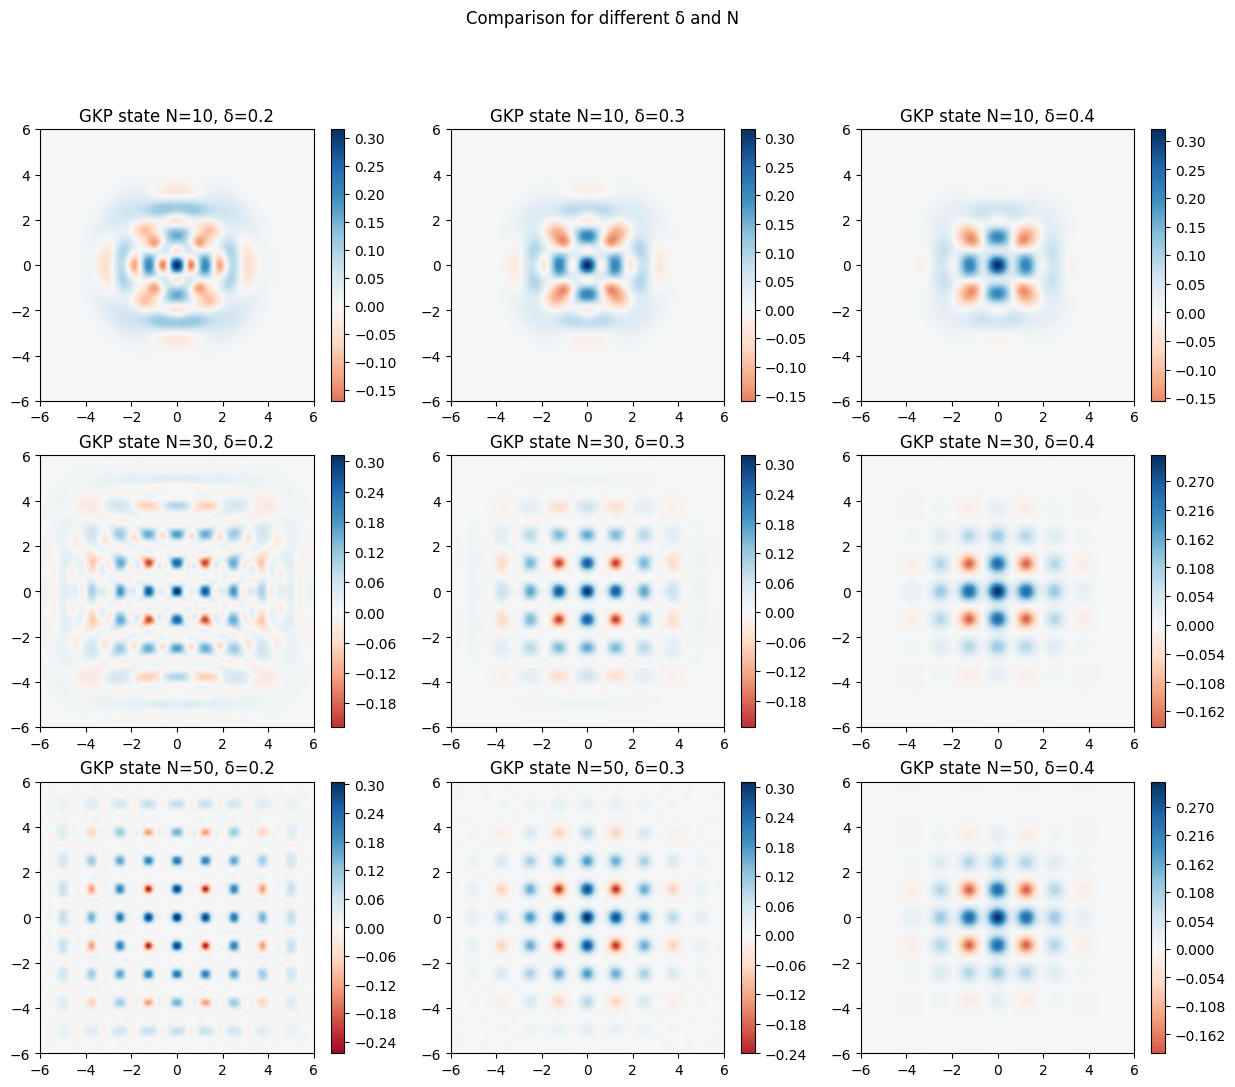

In [14]:
# HIGH DIMENSIONALITY NEEDED
N_ = 30
bound = 6
xvec = np.linspace(-bound,bound,200)
yvec = np.linspace(-bound,bound,200)
cmap='RdBu'

N_list = [10, 30, 50]
delta_list = [0.2, 0.3, 0.4]
n_delta = len(delta_list)
n_N = len(N_list)
fig, axes = plt.subplots(n_N, n_delta, figsize=(5*n_delta,4*n_N))
for (i, N_) in enumerate(N_list) :
    for (j, delta) in enumerate(delta_list):
        psi_gkp = gkp_state(delta, N_)
        plot_wigner(psi_gkp, xvec, yvec, fig, axes[i,j], cmap, f'GKP state N={N_}, δ={delta}')
        
fig.suptitle("Comparison for different δ and N")
plt.show()

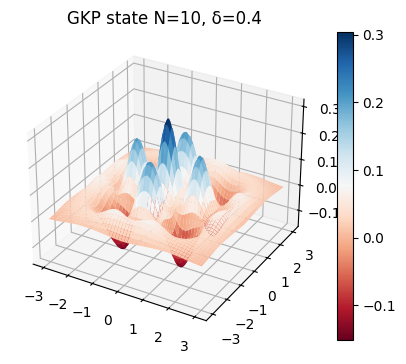

In [15]:
def plot_wigner_3D(psi, xvec, yvec, fig, ax, cmap, title="Wigner"):
    rho = qutip.ket2dm(psi)
    wigner = qutip.wigner(rho, xvec, yvec)
    X = np.tile(xvec, (len(yvec), 1)).transpose()
    Y = np.tile(yvec, (len(xvec), 1))
    plot = ax.plot_surface(X,Y, wigner, cmap=cmap)
    ax.set_title(title)
    fig.colorbar(plot, ax=ax)

delta, N_ = 0.4, 10
bound_3d = 3
xvec_3d = np.linspace(-bound_3d,bound_3d,200)
yvec_3d = np.linspace(-bound_3d,bound_3d,200)
fig, ax = plt.subplots(1, 1, figsize=(5,4), subplot_kw={"projection": "3d"})
plot_wigner_3D(gkp_state(delta, N_), xvec_3d, yvec_3d, fig, ax, cmap, f'GKP state N={N_}, δ={delta}')

According to _Equivalence of approximate Gottesman-Kitaev-Preskill codes_ (Takaya Matsuura, Hayata Yamasaki, Masato Koashi), for a finitely squeezed GKP with squeezing parameter $\sigma$, the average photon number is approximately $\frac1{4\sigma^2}-\frac12$ when $-10\log_{10}(2\sigma^2)\gg1$

In [16]:
rho_gkp = qutip.ket2dm(psi_gkp)
N_ = rho_gkp.shape[0]
print(qutip.expect(qutip.num(N_), rho_gkp), 1/(4*delta**4)-1/2)

2.6426925175432276 9.265624999999998


In [17]:
#N = 10
t_list_gkp = np.linspace(0, 0.5, 10)
delta = 0.4
psi_gkp = gkp_state(delta, N)
rho_gkp = qutip.ket2dm(psi_gkp)
noisy_gkp_list = create_states(N, t_list_gkp, rho_gkp, kappa)

if RUN_GKP:
    result_gkp, result_gkp_loss, result_gkp_th = perform_protocol(N,noisy_gkp_list, F_list[:10],
                                                                  [1,3], losses=False)

In [18]:
# show results
if RUN_GKP:
    plot_all(t_list_gkp, result_gkp, result_gkp_loss, [(result_gkp_th[0], "No VD"), 
                        (result_gkp_th[1], "Theoretical 3-mode")], (1,4), "GKP state", losses=False)

### Conclusion
VD works well with binomial state (probably because it is quite similar to Fock states) and doesn’t work at all with cat states. The protocol even theoretically gives a worse result than without VD

For GKP states it doesn’t seem to work well either

# ----- Theoretical plots -----

In [19]:
nb_points = 1000
nb_curves = 9 # modes, starts at 1
nb_n = 50 # Fock state, starts at 1
gamma_list_complete = np.linspace(0,1,nb_points)
theoretical_curves = np.zeros((nb_n, nb_curves, nb_points))
names = [["" for j in range(nb_curves)] for i in range(nb_n)]

for n_ in range(1,nb_n+1):
    theoretical_curves[n_-1][0] = n_ * np.exp(-gamma_list_complete)
    names[n_-1][0] = f"No VD, state |{n_}>"

temporary = (np.exp(kappa * gamma_list_complete)-1)
for n_ in range(1,nb_n+1):
    for M in range(1,nb_curves):
        numerator = np.zeros_like(gamma_list_complete, dtype='O')
        denominator = np.zeros_like(gamma_list_complete, dtype='O')
        for k in range(n_+1):
            coef = (math.comb(n_, k)**M)
            numerator+=(n_-k)*coef *temporary**(M*k)
            denominator+=coef *temporary**(M*k)
        theoretical_curves[n_-1][M] = numerator/denominator
        names[n_-1][M] = f"{M+1}-mode VD, state |{n_}>"

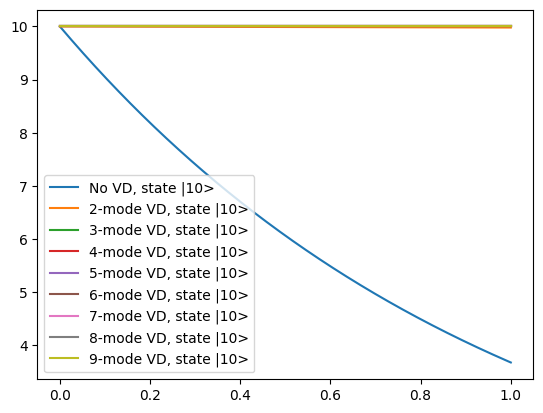

In [20]:
for i in range(9,10):
    for j in range(nb_curves):
        plt.plot(gamma_list_complete, theoretical_curves[i][j], label=names[i][j])
plt.legend()

0.10010010010010009


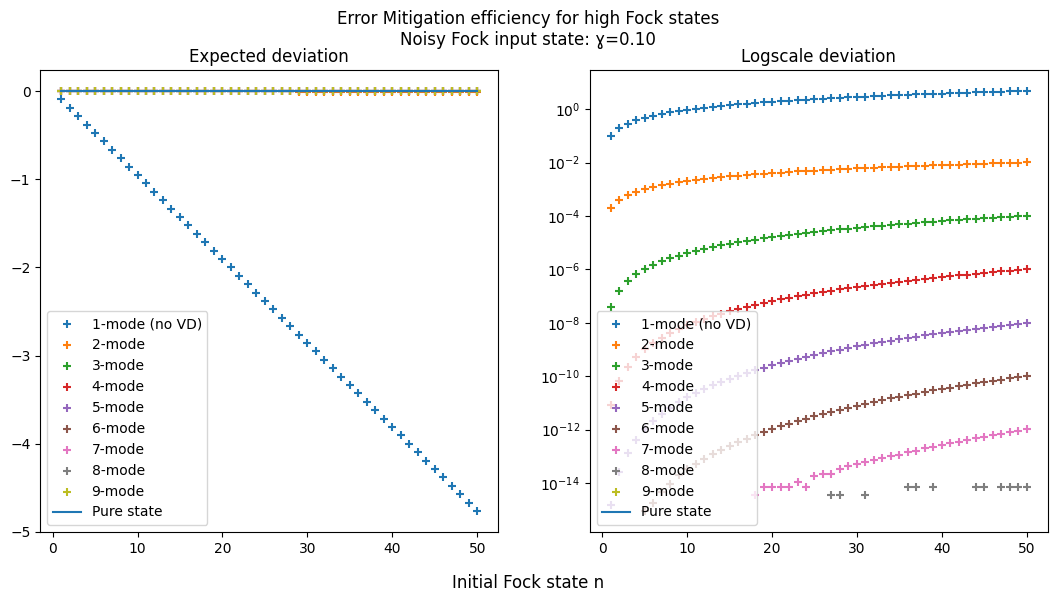

In [21]:
f, axes = plt.subplots(1, 2, figsize=(13,6))
fixed_gamma_index=100
for j in range(nb_curves):
    axes[0].scatter(np.arange(1,nb_n+1), theoretical_curves[:,j,fixed_gamma_index] -np.arange(1,nb_n+1),
                marker='+', label=f"{j+1}-mode" + (" (no VD)" if (j==0) else ""))
    axes[1].scatter(np.arange(1,nb_n+1), -theoretical_curves[:,j,fixed_gamma_index] + np.arange(1,nb_n+1),
                marker='+', label=f"{j+1}-mode" + (" (no VD)" if (j==0) else ""))
axes[0].plot(np.arange(1,nb_n+1), np.full((nb_n), 0), label="Pure state" )
axes[1].plot(np.arange(1,nb_n+1), np.full((nb_n), 0), label="Pure state" )

axes[0].legend()
axes[0].set_title("Expected deviation")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_title("Logscale deviation")

f.supxlabel("Initial Fock state n")
f.suptitle(f"Error Mitigation efficiency for high Fock states\nNoisy Fock input state: ɣ={gamma_list_complete[fixed_gamma_index]:.2f}")

print(gamma_list_complete[fixed_gamma_index])

On the right plot we see pretty clearly the exponential scaling of the correction as the number of modes increases. In fact, the spacing is the same between each curve, because we are looking at $\log(p^M)=M*\log p$ for different values of M.

We also see that the deviation seems to stabilize, but looking at the left plot it rather seems that it grows linearly with $n$.

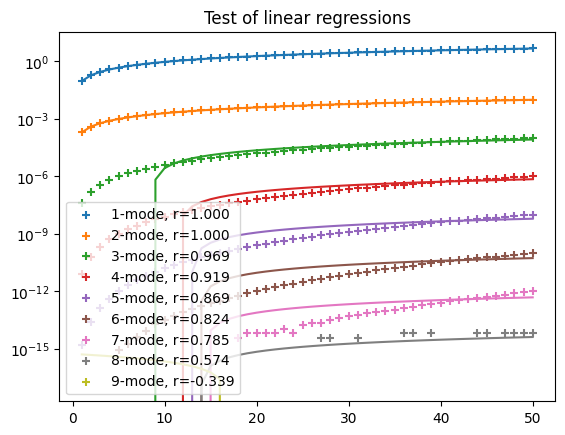

In [22]:
import scipy.stats as sts
x = np.arange(1, nb_n+1)
for j in range(nb_curves):
    a = x-theoretical_curves[:,j,fixed_gamma_index]
    slope, intercept, r, p, se = sts.linregress(x, a)
    plt.scatter(x, a, marker='+', label=f"{j+1}-mode, r={r:.3f}")
    plt.plot(x, slope*x+intercept)
plt.yscale("log")
plt.title("Test of linear regressions")
plt.legend()

Ok for few modes but as soon as we go further it’s not that clear

Now let’s try plotting as a function of number of modes.

0.10010010010010009


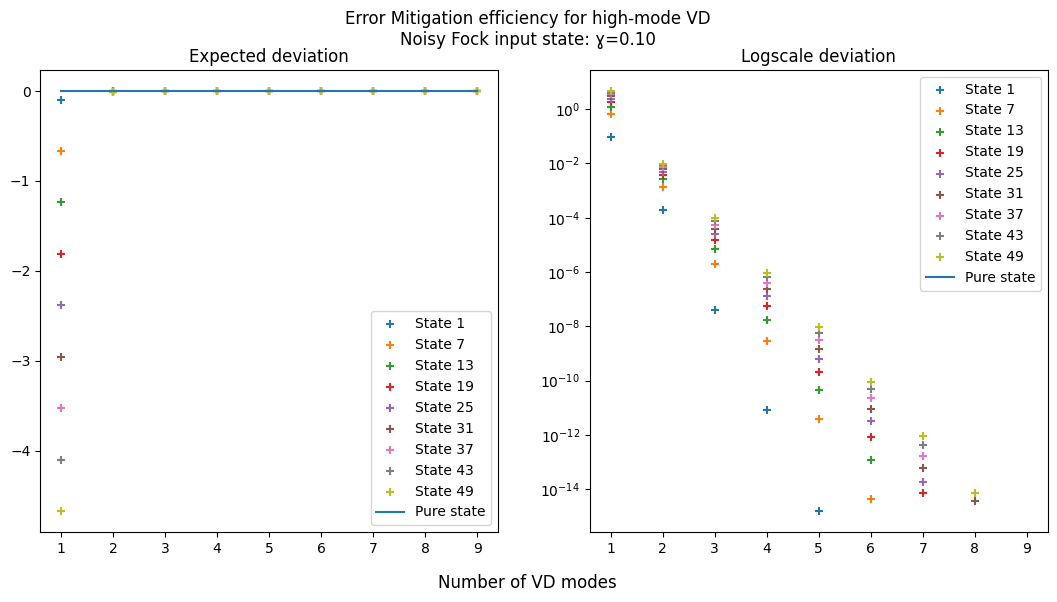

In [23]:
f, axes = plt.subplots(1, 2, figsize=(13,6))
fixed_gamma_index=100
for i in range(0,nb_n, 6):
    axes[0].scatter(np.arange(1,nb_curves+1), theoretical_curves[i,:,fixed_gamma_index] - (i+1),
                marker='+', label=f"State {i+1}")
    axes[1].scatter(np.arange(1,nb_curves+1), -theoretical_curves[i, :,fixed_gamma_index] +(i+1),
                marker='+', label=f"State {i+1}")
axes[0].plot(np.arange(1,nb_curves+1), np.full((nb_curves), 0), label="Pure state" )
axes[1].plot(np.arange(1,nb_curves+1), np.full((nb_curves), 0), label="Pure state" )

axes[0].legend()
axes[0].set_title("Expected deviation")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_title("Logscale deviation")

f.supxlabel("Number of VD modes")
f.suptitle(f"Error Mitigation efficiency for high-mode VD\nNoisy Fock input state: ɣ={gamma_list_complete[fixed_gamma_index]:.2f}")

print(gamma_list_complete[fixed_gamma_index])

## ----- Plots for report and tests ------

Text(0, 0.5, 'Coefficient')

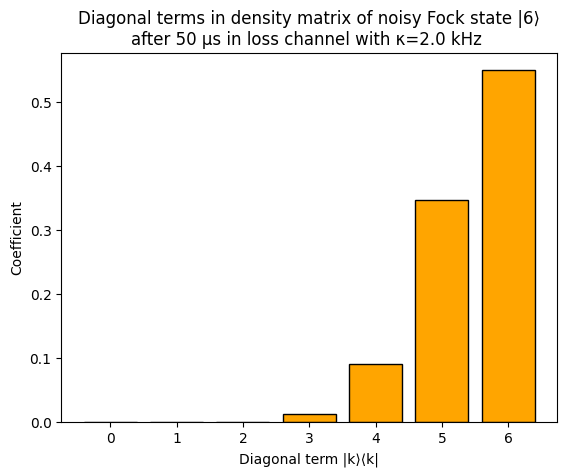

In [24]:
N=10
n=6
t=50
rho = create_states(N, [t], qutip.fock_dm(N,n), kappa, 1)[0]
plt.bar(np.arange(n+1),np.abs(np.diag(rho))[:n+1], color='orange', linestyle='-', edgecolor='black')
plt.title(f"Diagonal terms in density matrix of noisy Fock state |{n}⟩\nafter {t} μs in loss channel with κ={1000*kappa} kHz ")
plt.xlabel("Diagonal term |k⟩⟨k|")
plt.ylabel("Coefficient")

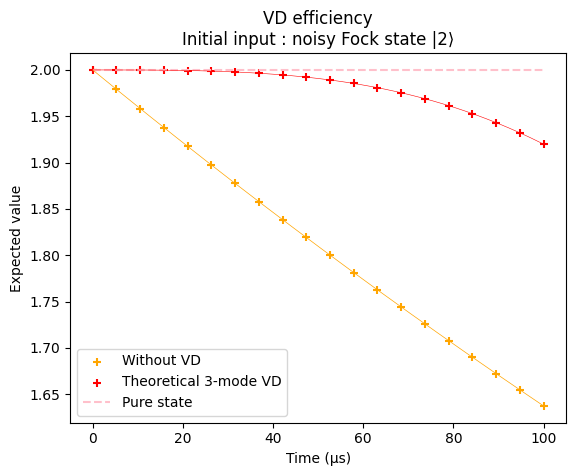

In [25]:
# same t_list as the beginning
t_max = 100
n=2
t_list = np.linspace(0,t_max,nb_samples)
rho_list = create_states(N, t_list, rho_0 = qutip.fock_dm(N,n), kappa=kappa)

r, r_loss, r_th = perform_protocol(N, rho_list, [], [1,3], False, None)
r_th_1, r_th_3 = r_th
plot_all(t_list, r, r_loss, [(r_th_1, "Without VD"), (r_th_3, "Theoretical 3-mode VD")],
         title="Fock state |2⟩", kappa=kappa, losses=False, show_only_th=True, show_curves=n)

In [26]:
np.r_[1:5,5:1:-1]

array([1, 2, 3, 4, 5, 4, 3, 2])

In [27]:
np.r_[2:10:5j]

array([ 2.,  4.,  6.,  8., 10.])